# Introduction

- This document reports some basic analysis of the credit history records
- The purpose is to identity possible issues, preprocessing steps, and modeling insights

In [1]:
import collections
import numpy as np
import pandas as pd
import seaborn as sns
from IPython import display

In [2]:
H=pd.read_csv('summary_credit_history.csv')
H

,ID,MONTHS_BALANCE,STATUS
0,5001711,0,X
1,5001711,-1,0
2,5001711,-2,0
3,5001711,-3,0
4,5001712,0,C
...,...,...,...
1048570,5150487,-25,C
1048571,5150487,-26,C
1048572,5150487,-27,C
1048573,5150487,-28,C


In [3]:
H.groupby('ID')['MONTHS_BALANCE'].is_monotonic_decreasing.all()

True

## Remove client with only X (no loan) status

- there are about 10% clients who never had loans during all months
- this analysis removes such clients since there are no supervising information
- although it is unclear why such clients are included in the credit hisotry file
- this step might be changed if we know more data details

In [4]:
C=H.groupby('ID')['STATUS'].value_counts().unstack(fill_value=0)
ID_NoLoan=C.index[C.sum(axis=1)==C['X']]
C.shape, len(ID_NoLoan)

((45985, 8), 4536)

In [5]:
H=H[~H['ID'].isin(ID_NoLoan)]
H

,ID,MONTHS_BALANCE,STATUS
0,5001711,0,X
1,5001711,-1,0
2,5001711,-2,0
3,5001711,-3,0
4,5001712,0,C
...,...,...,...
1048570,5150487,-25,C
1048571,5150487,-26,C
1048572,5150487,-27,C
1048573,5150487,-28,C


## How many clients always pay off every month?

- there are only 1417/41449 perfect clients
- this rate might be better for a fixed period, e.g., the last couple of months

In [6]:
C=H.groupby('ID')['STATUS'].value_counts().unstack(fill_value=0)
ID_perfect=C.index[C.sum(axis=1)==C[['C','X']].sum(axis=1)]
C.shape, len(ID_perfect)

((41449, 8), 1417)

## How many clients always pay off within one or two months past due?

- unlike perfect clients, there are many good clients: 87% past due only one month, 98% past due at most two months
- in other words, very few clients have long past due payments
- again these rates might be better for some periods

In [7]:
C=H.groupby('ID')['STATUS'].value_counts().unstack(fill_value=0)
ID_Good=C.index[C[['1','2','3','4','5']].sum(axis=1)==0]
C.shape, len(ID_Good)

((41449, 8), 36099)

In [8]:
C=H.groupby('ID')['STATUS'].value_counts().unstack(fill_value=0)
ID_Good=C.index[C[['2','3','4','5']].sum(axis=1)==0]
C.shape, len(ID_Good)

((41449, 8), 40782)

# Descriptive Analytics

## Counts

- this section checks the value counts of all columns
- the purpose is to identify any obvious issues
- status:
    - 0: 1-29 days past due
    - 1: 30-59 days past due
    - 2: 60-89 days overdue
    - 3: 90-119 days overdue
    - 4: 120-149 days overdue
    - 5: Overdue or bad debts, write-offs for more than 150 days

In [9]:
H['ID'].value_counts()

5078802    61
5059854    61
5060198    61
5017911    61
5120092    61
           ..
5088722     1
5096514     1
5025928     1
5010859     1
5116447     1
Name: ID, Length: 41449, dtype: int64

In [10]:
H['MONTHS_BALANCE'].value_counts()

-1     30703
-2     30556
-3     30282
 0     30239
-4     29880
       ...  
-56     1954
-57     1538
-58     1175
-59      777
-60      394
Name: MONTHS_BALANCE, Length: 61, dtype: int64

In [11]:
H['STATUS'].value_counts()

C    442031
0    383120
X    107707
1     11090
5      1693
2       868
3       320
4       223
Name: STATUS, dtype: int64

## Case Example

- this section checks two client cases
- one client has the most records
- one client has the fewest records

In [12]:
h=H.query('ID in (5078802, 5116447)')
h['STATUS'].value_counts()

0    20
5    17
C    11
1     9
2     2
4     1
3     1
X     1
Name: STATUS, dtype: int64

In [13]:
display.HTML(h.to_html()) # so all rows are displayed for inspection

,ID,MONTHS_BALANCE,STATUS
609443,5078802,0,C
609444,5078802,-1,C
609445,5078802,-2,C
609446,5078802,-3,C
609447,5078802,-4,C
609448,5078802,-5,C
609449,5078802,-6,C
609450,5078802,-7,C
609451,5078802,-8,C
609452,5078802,-9,C


## Dependency

- is there temporal dependency between default rate?
- for each month and all clients, the for loop checks the correlation beteween default in the `PREVIOUS` and `NEXT` several months.
- according to the plot, the conditional probability $\Pr(\text{default}_\text{soon}|\text{default}_\text{recently})$ is consitently higher than 0.8.
- for the first several months, the conditional probability is even higher, possibly due to limited data.
- the results suggest that feature engineering with credit history might improve dynamic models.

In [14]:
first_month=H['MONTHS_BALANCE'].min()
last_month=H['MONTHS_BALANCE'].max()
first_month, last_month

(-60, 0)

<AxesSubplot:>

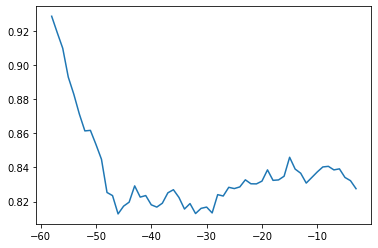

In [15]:
R={}
for m in range(first_month+2, last_month-2):
    before=H[H['MONTHS_BALANCE'].between(m-2, m)]
    after=H[H['MONTHS_BALANCE'].between(m+1, m+3)]
    before_counts=before.groupby('ID')['STATUS'].value_counts().unstack(fill_value=0)
    after_counts=after.groupby('ID')['STATUS'].value_counts().unstack(fill_value=0)
    ID=before_counts.index.intersection(after_counts.index)
    before_default=before_counts.loc[ID, before_counts.columns.intersection(['0','1','2','3','4','5'])].sum(axis=1)>0
    after_default=after_counts.loc[ID, after_counts.columns.intersection(['0','1','2','3','4','5'])].sum(axis=1)>0
    R[m]=(before_default & after_default).sum() / before_default.sum()
R=pd.Series(R)
R.plot()

# API

The function API.get_labels() will be used for further analysis

In [16]:
import API
labels=API.get_labels(['1','2','3','4','5'])
labels.value_counts()

0    36099
1     5350
Name: label, dtype: int64

In [17]:
API.get_labels(list('012345')).value_counts()

1    40032
0     1417
Name: label, dtype: int64

In [18]:
API.get_labels(list('2345')).value_counts()

0    40782
1      667
Name: label, dtype: int64